#Import các thư viện cần thiết

In [ ]:
# ===============================
# IMPORT CÁC THƯ VIỆN CẦN THIẾT
# ===============================

import tensorflow as tf   # Thư viện chính cho học sâu (Deep Learning)
from tensorflow.keras.applications import ResNet50   # Import mô hình ResNet50 có sẵn từ Keras (đã được huấn luyện trước)
from tensorflow.keras.applications.resnet50 import preprocess_input  # Hàm tiền xử lý ảnh phù hợp với ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Dùng để tạo và biến đổi dữ liệu ảnh đầu vào

# --- Các lớp layer sẽ được dùng để xây dựng mô hình mới dựa trên ResNet50 ---
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, concatenate
# GlobalAveragePooling2D: thu gọn feature map thành vector (giảm chiều)
# Dense: lớp kết nối đầy đủ (Fully Connected Layer)
# Dropout: giảm overfitting bằng cách tạm thời bỏ qua một số neuron trong quá trình huấn luyện
# Flatten: làm phẳng input thành vector 1 chiều
# concatenate: kết hợp các tensor

from tensorflow.keras.models import Model  # Dùng để tạo mô hình Keras tùy chỉnh
from tensorflow.keras.optimizers import Adam  # Bộ tối ưu hóa Adam (phổ biến trong Deep Learning)
from tensorflow.keras.regularizers import l2 # Dùng cho L2 regularization
from tensorflow.keras.layers import BatchNormalization # Dùng cho Batch Normalization


# --- Các callback giúp kiểm soát quá trình huấn luyện ---
from tensorflow.keras.callbacks import (
    ModelCheckpoint,     # Tự động lưu lại mô hình tốt nhất trong quá trình huấn luyện
    ReduceLROnPlateau,   # Giảm tốc độ học (learning rate) khi mô hình không cải thiện
    EarlyStopping         # Dừng sớm nếu mô hình không còn tiến bộ (tránh overfitting)
)

# --- Các công cụ đánh giá mô hình ---
from sklearn.metrics import classification_report, confusion_matrix
# classification_report: in ra độ chính xác, recall, F1-score cho từng lớp
# confusion_matrix: ma trận nhầm lẫn để xem mô hình dự đoán sai ở đâu

import numpy as np             # Thư viện xử lý mảng số học
import matplotlib.pyplot as plt # Dùng để vẽ biểu đồ, hình ảnh
import os                      # Dùng để thao tác với thư mục, đường dẫn file

#Tiền xử lý ảnh

In [ ]:
# --- CẤU HÌNH SIÊU THAM SỐ HUẤN LUYỆN ---

# Kích thước ảnh đầu vào — ResNet50 được huấn luyện gốc với 224x224
IMG_SIZE = 224

# Batch size: giá trị 32 là phổ biến, nhưng nếu GPU mạnh (>=8GB), có thể tăng lên 64 để huấn luyện nhanh hơn.
BATCH_SIZE = 32

# Số epoch huấn luyện phần đầu (chỉ huấn luyện head mới)
# => Không nên quá cao vì phần base_model đang bị đóng băng, dữ liệu ít sẽ dễ overfit.
EPOCHS_HEAD = 10

# Số epoch fine-tune (mở một phần ResNet để học sâu hơn)
# => 20 là ổn, nhưng có thể dùng EarlyStopping để tự động dừng khi loss không giảm.
EPOCHS_FINE = 20

train_dir = "/content/drive/MyDrive/Colab Notebooks/tap-trending/train"
val_dir = "/content/drive/MyDrive/Colab Notebooks/tap-trending/valid"
test_dir = "/content/drive/MyDrive/Colab Notebooks/tap-trending/test"

In [ ]:

# ===============================
# KIỂM TRA SỐ ẢNH MỖI LỚP
# ===============================
def count_images(dirpath):
    counts = {}
    for cls in os.listdir(dirpath):
        p = os.path.join(dirpath, cls)
        if os.path.isdir(p):
            counts[cls] = len([f for f in os.listdir(p) if f.lower().endswith(('.png','.jpg','.jpeg'))])
    return counts

print("Train:", count_images(train_dir))
print("Val:", count_images(val_dir))
print("Test:", count_images(test_dir))

Train: {'unhealthy': 1171, 'healthy': 1228}
Val: {'healthy': 76, 'unhealthy': 75}
Test: {'healthy': 56, 'unhealthy': 82}


In [ ]:
# =============================== # TẠO DATA GENERATOR # ===============================
# Cấu hình tăng cường dữ liệu
train_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input, rotation_range=10, # giảm góc xoay (ít biến dạng hơn)
  width_shift_range=0.05, # giảm dịch chuyển ngang
  height_shift_range=0.05, # giảm dịch chuyển dọc
  zoom_range=0.1, # giảm zoom
  horizontal_flip=True, # vẫn cho phép lật ngang
  brightness_range=[0.9, 1.1], # thêm thay đổi độ sáng nhẹ
  fill_mode='nearest' ) # ImageDataGenerator giúp đọc ảnh từ thư mục và áp dụng tiền xử lý (preprocess_input) cho phù hợp với ResNet50
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# --- Tạo generator cho tập huấn luyện ---
train_gen = train_datagen.flow_from_directory(
    train_dir, # Đường dẫn tới thư mục chứa ảnh huấn luyện
    target_size=(IMG_SIZE, IMG_SIZE), # Kích thước ảnh đầu vào (phải khớp với kích thước mà ResNet50 yêu cầu)
    batch_size=BATCH_SIZE, # Số lượng ảnh được nạp vào mỗi lần huấn luyện (batch)
    class_mode='categorical', # Dạng nhãn là one-hot vector (dùng cho bài toán phân loại nhiều lớp)
    shuffle=True # Trộn ngẫu nhiên dữ liệu để mô hình không học theo thứ tự
    )
# --- Tạo generator cho tập validation ---
val_gen = val_datagen.flow_from_directory(
    val_dir, # Đường dẫn tới thư mục chứa ảnh validation
    target_size=(IMG_SIZE, IMG_SIZE), # Cũng resize ảnh về cùng kích thước
    batch_size=BATCH_SIZE, # Kích thước batch giống train
    class_mode='categorical', # One-hot vector như trên
    shuffle=False, # Không trộn dữ liệu để giữ thứ tự cố định (phục vụ đánh giá và confusion matrix)
    classes=['healthy', 'unhealthy'] # Ép thứ tự class cố định: 0 = healthy, 1 = unhealthy
    )
    # --- Lấy ra số lớp của bài toán (ví dụ: 2 lớp = healthy và unhealthy) ---
num_classes = train_gen.num_classes
print("Số lớp:", num_classes)

Found 2399 images belonging to 2 classes.
Found 151 images belonging to 2 classes.
Số lớp: 2


In [ ]:
# --- Import hàm tính trọng số lớp (class weight) ---
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# --- Tính toán trọng số cho từng lớp (class) ---
class_weights = compute_class_weight(
    class_weight='balanced',               # Tùy chọn 'balanced' để tự động cân bằng trọng số dựa trên tần suất xuất hiện
    classes=np.unique(train_gen.classes),  # Danh sách các lớp có trong tập huấn luyện (ví dụ: [0, 1])
    y=train_gen.classes                    # Mảng chứa toàn bộ nhãn (labels) của dữ liệu huấn luyện
)

# --- Chuyển kết quả thành dạng dictionary để dễ dùng trong model.fit() ---
# Ví dụ: {0: 1.2, 1: 0.8} nghĩa là lớp 0 nặng hơn lớp 1
class_weights = dict(enumerate(class_weights))

# --- In ra trọng số lớp để kiểm tra ---
print("⚖️ Class Weights:", class_weights)


⚖️ Class Weights: {0: np.float64(0.9767915309446255), 1: np.float64(1.024338172502135)}


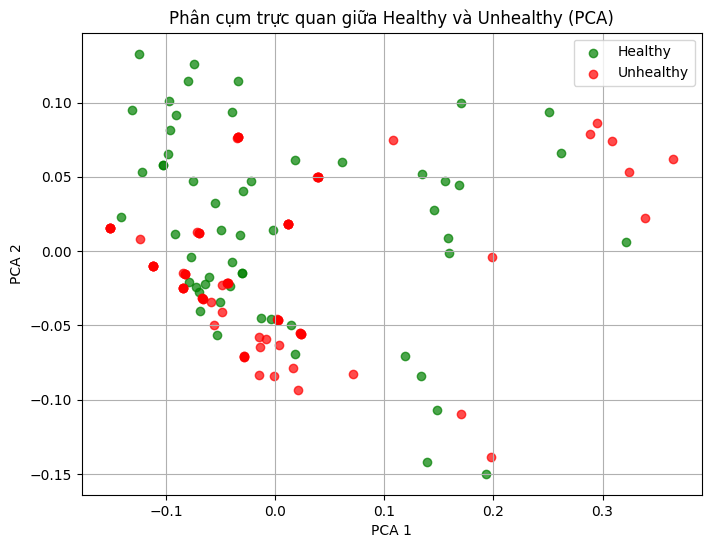

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.decomposition import PCA
import os

# Đường dẫn dataset
healthy_path = '/content/drive/MyDrive/Colab Notebooks/tap-trending/test/healthy'
unhealthy_path = '/content/drive/MyDrive/Colab Notebooks/tap-trending/test/unhealthy'

# Hàm trích xuất đặc trưng màu và kết cấu
def extract_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Đặc trưng màu (histogram 3 kênh)
    hist_b = cv2.calcHist([img], [0], None, [32], [0, 256])
    hist_g = cv2.calcHist([img], [1], None, [32], [0, 256])
    hist_r = cv2.calcHist([img], [2], None, [32], [0, 256])
    color_feature = np.concatenate([hist_b, hist_g, hist_r]).flatten()
    color_feature = color_feature / np.sum(color_feature)

    # Đặc trưng kết cấu (Local Binary Pattern)
    lbp = local_binary_pattern(img_gray, P=8, R=1, method="uniform")
    (hist_lbp, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, 10),
                                 range=(0, 9))
    hist_lbp = hist_lbp.astype("float")
    hist_lbp /= (hist_lbp.sum() + 1e-7)

    return np.concatenate([color_feature, hist_lbp])

# Đọc dữ liệu
features = []
labels = []
paths = []

for folder, label in [(healthy_path, 'Healthy'), (unhealthy_path, 'Unhealthy')]:
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            path = os.path.join(folder, filename)
            f = extract_features(path)
            features.append(f)
            labels.append(label)
            paths.append(path)

features = np.array(features)

# Giảm chiều bằng PCA để hiển thị trực quan
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# Vẽ phân cụm
plt.figure(figsize=(8,6))
for label, color in [('Healthy', 'green'), ('Unhealthy', 'red')]:
    idx = np.where(np.array(labels) == label)
    plt.scatter(features_2d[idx,0], features_2d[idx,1], c=color, label=label, alpha=0.7)

plt.title('Phân cụm trực quan giữa Healthy và Unhealthy (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()


# Xây dựng mô hình Resnet50

In [ ]:
# --- Khởi tạo mô hình nền (base model) từ ResNet50 ---
base_model = ResNet50(
    weights='imagenet', # Dùng trọng số đã huấn luyện sẵn trên bộ dữ liệu ImageNet (transfer learning)
    include_top=False, # Không dùng phần fully connected (phần classification gốc của ResNet50)
    input_shape=(IMG_SIZE, IMG_SIZE, 3) # Kích thước đầu vào ảnh RGB (cao, rộng, 3 kênh màu)
    )
# --- Đóng băng (freeze) các lớp của ResNet50 ---
base_model.trainable = False
# Nghĩa là trong giai đoạn đầu, chỉ huấn luyện các lớp mới thêm bên trên.
# Các trọng số gốc của ResNet50 (đã học được đặc trưng chung như biên, màu, texture) sẽ không thay đổi.
# Việc này giúp mô hình hội tụ nhanh hơn và tránh overfitting khi dữ liệu ít.
# --- Xây dựng phần đầu ra (head) mới cho bài toán của bạn ---
x = base_model.output # Lấy đầu ra từ mô hình ResNet50
x = GlobalAveragePooling2D()(x) # Thu gọn toàn bộ feature map thành vector (giúp giảm số tham số)
x = Dense(512, activation='relu')(x) # Thêm một lớp Fully Connected 512 node để học đặc trưng mới
x = Dropout(0.4)(x) # Thêm Dropout để giảm overfitting (40% node bị tắt ngẫu nhiên)
outputs = Dense(num_classes, activation='softmax')(x) # Lớp cuối cùng, kích thước bằng số lớp (num_classes)
 # Dùng softmax để xuất xác suất cho từng lớp (ví dụ: healthy / unhealthy) # --- Kết hợp toàn bộ thành mô hình hoàn chỉnh ---
model = Model(inputs=base_model.input, outputs=outputs) # --- Hiển thị cấu trúc mô hình --- model.summary()
 # Dòng này in ra toàn bộ các lớp (layers), số tham số (params) và kích thước đầu ra của từng tầng.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# COMPILE: Giữ nguyên
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# CALLBACKS tối ưu
ckpt = ModelCheckpoint(
    filepath=f"best_model_fold_1.keras",  # dùng định dạng .keras mới (nhanh hơn .h5)
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,   # lưu full model (an toàn khi resume)
    verbose=0                  # tắt log để tiết kiệm thời gian I/O
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,                # giảm nhanh hơn để mô hình hội tụ sớm
    min_lr=1e-6,
    verbose=0
)

early_stop = EarlyStopping(
    monitor='val_loss',        # chuyển sang val_loss (ổn định hơn)
    mode='min',
    patience=3,                # dừng sớm hơn
    restore_best_weights=True,
    verbose=0
)


Using layer 'conv5_block3_3_conv' for feature map visualization.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


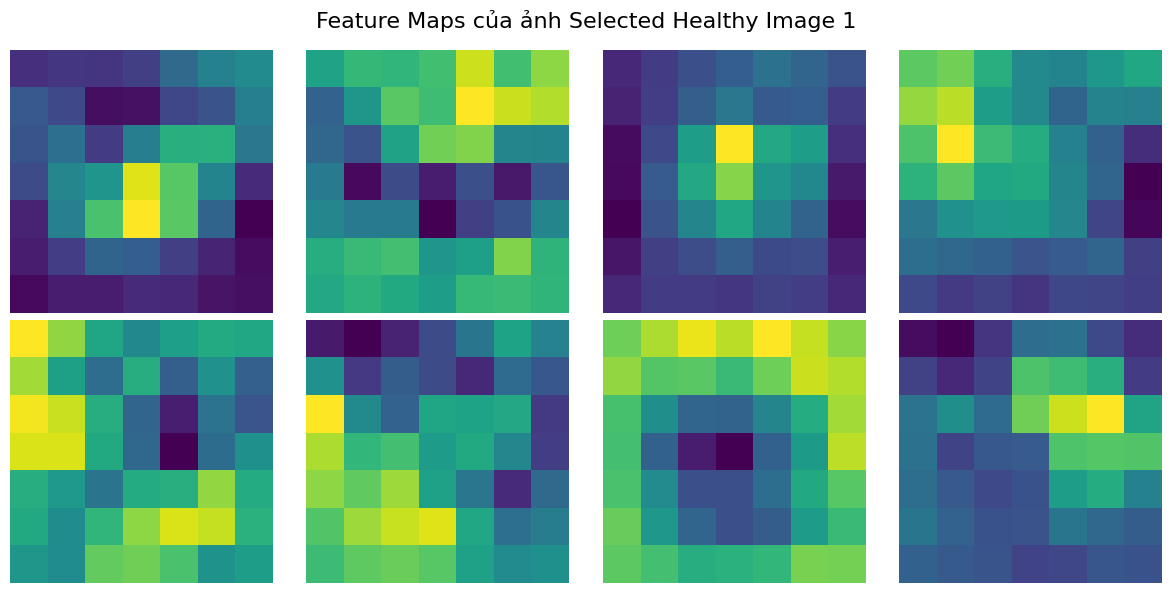

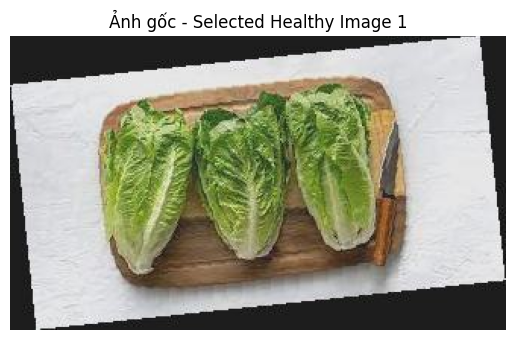

Using layer 'conv5_block3_3_conv' for feature map visualization.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


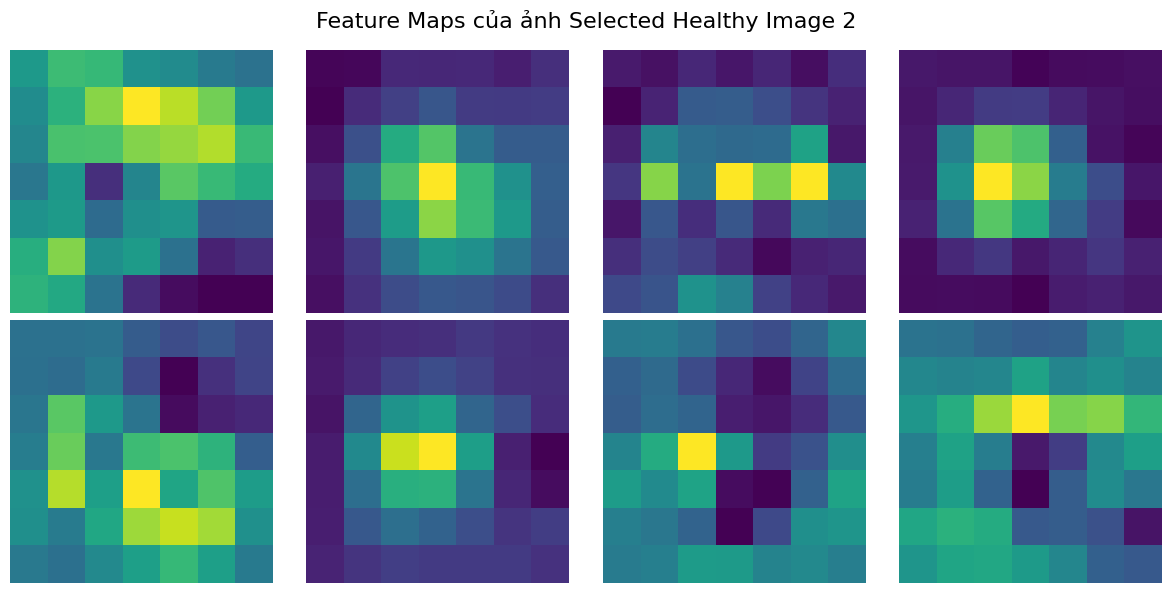

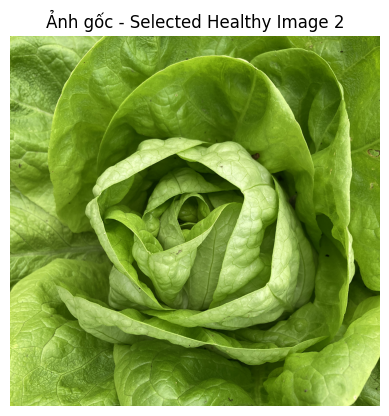

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Sử dụng các ảnh đã chọn
healthy_sample_selected = "/content/drive/MyDrive/Colab Notebooks/tap-trending/test/healthy/augmented_29.jpg"
unhealthy_sample_selected = "/content/drive/MyDrive/Colab Notebooks/tap-trending/test/healthy/h88_1.png"


# Hàm hiển thị ảnh gốc + feature map
def visualize_feature_maps(img_path, model, title):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Find the last convolutional layer before pooling
    suitable_layer_name = None
    for layer in reversed(model.layers):
        # Look for convolutional layers (Conv2D)
        if isinstance(layer, tf.keras.layers.Conv2D):
            suitable_layer_name = layer.name
            break # Stop at the first Conv2D layer found when iterating in reverse

    if suitable_layer_name is None:
        print(f"Error: Could not find a suitable convolutional layer for visualization in {model.name}.")
        print("Available layers:", [layer.name for layer in model.layers])
        return

    print(f"Using layer '{suitable_layer_name}' for feature map visualization.")
    intermediate_model = tf.keras.Model(inputs=model.input,
                                        outputs=model.get_layer(suitable_layer_name).output)


    feature_maps = intermediate_model.predict(x)

    # Hiển thị
    fig, axes = plt.subplots(2, 4, figsize=(12,6))
    fig.suptitle(f'Feature Maps của ảnh {title}', fontsize=16)
    axes = axes.flatten()

    # Ensure we don't plot more feature maps than available
    num_feature_maps_to_plot = min(8, feature_maps.shape[-1])

    for i in range(num_feature_maps_to_plot):
        ax = axes[i]
        fm = feature_maps[0, :, :, i]
        fm = (fm - fm.min()) / (fm.max() - fm.min() + 1e-6)
        ax.imshow(fm, cmap='viridis')
        ax.axis('off')

    # Turn off any unused subplots
    for j in range(num_feature_maps_to_plot, 8):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    # Hiển thị ảnh gốc để so sánh
    img_bgr = cv2.imread(img_path)
    img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_bgr)
    plt.title(f'Ảnh gốc - {title}')
    plt.axis('off')
    plt.show()

# Tải ResNet50 pretrained
resnet_model = ResNet50(weights='imagenet', include_top=False)

# Hiển thị đặc trưng healthy
visualize_feature_maps(healthy_sample_selected, resnet_model, 'Selected Healthy Image 1')

# Hiển thị đặc trưng unhealthy
visualize_feature_maps(unhealthy_sample_selected, resnet_model, 'Selected Healthy Image 2')

Using layer 'conv5_block3_3_conv' for feature map visualization.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


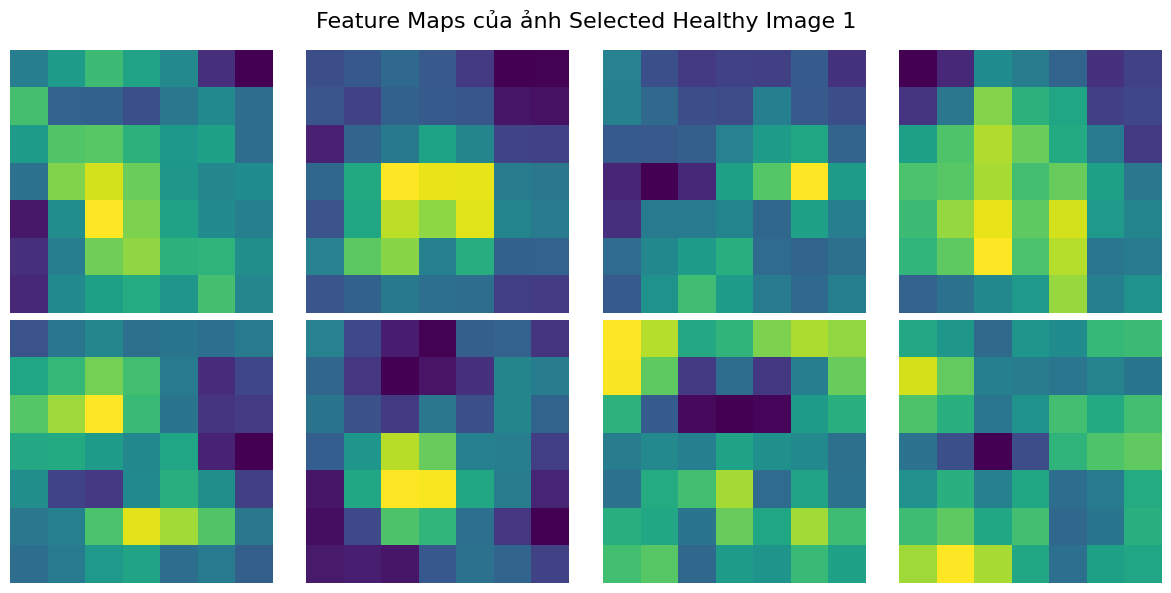

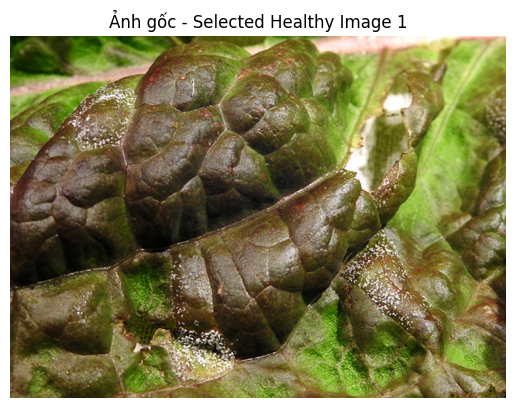

Using layer 'conv5_block3_3_conv' for feature map visualization.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


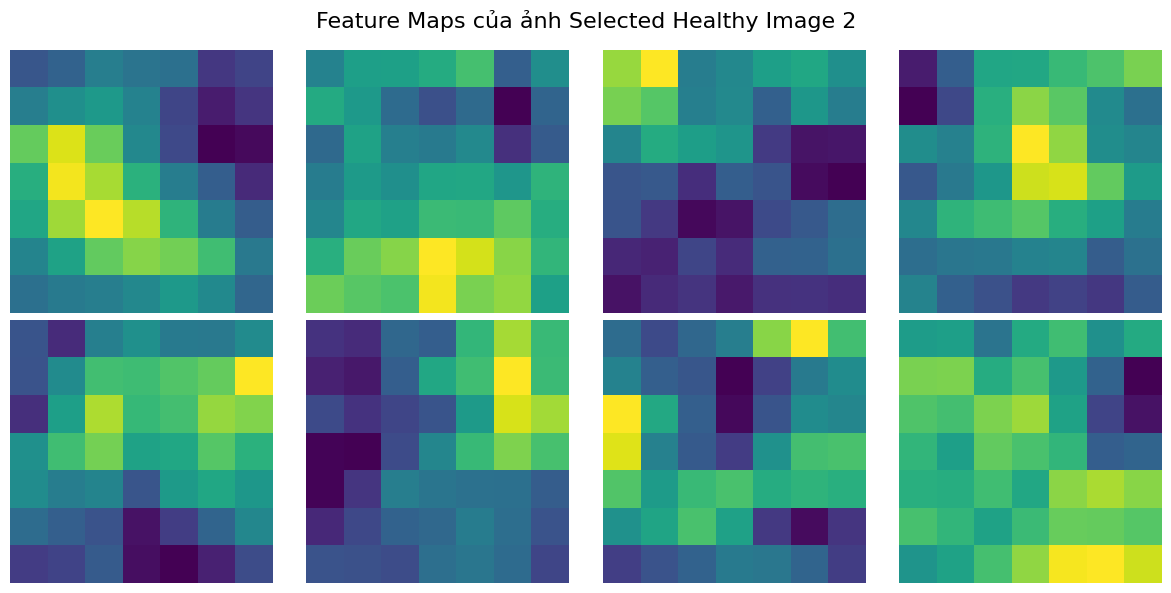

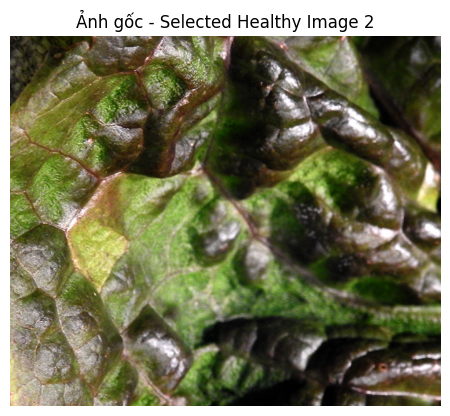

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

# Đường dẫn ảnh mẫu
# healthy_sample = os.path.join('/content/drive/MyDrive/Colab Notebooks/tap-trending/test/healthy',
#                               os.listdir('/content/drive/MyDrive/Colab Notebooks/tap-trending/test/healthy')[0])
# unhealthy_sample = os.path.join('/content/drive/MyDrive/Colab Notebooks/tap-trending/test/unhealthy',
#                                 os.listdir('/content/drive/MyDrive/Colab Notebooks/tap-trending/test/unhealthy')[0])

# Sử dụng các ảnh đã chọn
healthy_sample_selected = "/content/drive/MyDrive/Colab Notebooks/tap-trending/test/unhealthy/03_0.png"
unhealthy_sample_selected = "/content/drive/MyDrive/Colab Notebooks/tap-trending/test/unhealthy/04_2.png"


# Hàm hiển thị ảnh gốc + feature map
def visualize_feature_maps(img_path, model, title):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Find the last convolutional layer before pooling
    suitable_layer_name = None
    for layer in reversed(model.layers):
        # Look for convolutional layers (Conv2D)
        if isinstance(layer, tf.keras.layers.Conv2D):
            suitable_layer_name = layer.name
            break # Stop at the first Conv2D layer found when iterating in reverse

    if suitable_layer_name is None:
        print(f"Error: Could not find a suitable convolutional layer for visualization in {model.name}.")
        print("Available layers:", [layer.name for layer in model.layers])
        return

    print(f"Using layer '{suitable_layer_name}' for feature map visualization.")
    intermediate_model = tf.keras.Model(inputs=model.input,
                                        outputs=model.get_layer(suitable_layer_name).output)


    feature_maps = intermediate_model.predict(x)

    # Hiển thị
    fig, axes = plt.subplots(2, 4, figsize=(12,6))
    fig.suptitle(f'Feature Maps của ảnh {title}', fontsize=16)
    axes = axes.flatten()

    # Ensure we don't plot more feature maps than available
    num_feature_maps_to_plot = min(8, feature_maps.shape[-1])

    for i in range(num_feature_maps_to_plot):
        ax = axes[i]
        fm = feature_maps[0, :, :, i]
        fm = (fm - fm.min()) / (fm.max() - fm.min() + 1e-6)
        ax.imshow(fm, cmap='viridis')
        ax.axis('off')

    # Turn off any unused subplots
    for j in range(num_feature_maps_to_plot, 8):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    # Hiển thị ảnh gốc để so sánh
    img_bgr = cv2.imread(img_path)
    img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_bgr)
    plt.title(f'Ảnh gốc - {title}')
    plt.axis('off')
    plt.show()

# Tải ResNet50 pretrained
resnet_model = ResNet50(weights='imagenet', include_top=False)

# Hiển thị đặc trưng healthy
visualize_feature_maps(healthy_sample_selected, resnet_model, 'Selected Healthy Image 1')

# Hiển thị đặc trưng unhealthy
visualize_feature_maps(unhealthy_sample_selected, resnet_model, 'Selected Healthy Image 2')

## Training phase 1

In [ ]:

# ===============================
# GIAI ĐOẠN 1: HUẤN LUYỆN HEAD
# ===============================
history_head = model.fit(
    train_gen,
    epochs=EPOCHS_HEAD,
    validation_data=val_gen,
    callbacks=[ckpt, reduce_lr, early_stop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 483s 6s/step - accuracy: 0.7711 - loss: 0.4998 - val_accuracy: 0.9470 - val_loss: 0.2438 - learning_rate: 1.0000e-04
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 464s 6s/step - accuracy: 0.9654 - loss: 0.1114 - val_accuracy: 0.9338 - val_loss: 0.2457 - learning_rate: 1.0000e-04
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 462s 6s/step - accuracy: 0.9817 - loss: 0.0682 - val_accuracy: 0.9272 - val_loss: 0.3019 - learning_rate: 1.0000e-04
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 467s 6s/step - accuracy: 0.9834 - loss: 0.0596 - val_accuracy: 0.9338 - val_loss: 0.2710 - learning_rate: 5.0000e-05


## Training phase 2

In [ ]:
# ===============================
# GIAI ĐOẠN 2: FINE-TUNING
# ===============================
# MỞ KHÓA (UNFREEZE) CÁC LỚP CUỐI CỦA RESNET50
# Vòng lặp qua toàn bộ các lớp (layers) trong
for layer in base_model.layers:
  # Mở khóa lớp thuộc block cuối cùng của ResNet50
  if layer.name.startswith('conv5_'):
    layer.trainable = True
  # Mở khóa để các lớp này có thể được huấn luyện lại (fine-tune)
  # Giải thích:
  # - Khi mới khởi tạo ResNet50, ta đã đặt base_model.trainable = False → nghĩa là tất cả các lớp đều bị "đóng băng".
  # - Tuy nhiên, các lớp ở cuối mạng (conv5_block1, conv5_block2, conv5_block3)
  # là nơi chứa đặc trưng trừu tượng nhất, rất gần với bài toán của bạn (nhận diện bệnh lá).
  # - Việc mở khóa (unfreeze) các lớp cuối này giúp mô hình có thể **tinh chỉnh nhẹ** lại trọng số # sao cho phù hợp hơn với dữ liệu cụ thể của bạn (thay vì dữ liệu ImageNet ban đầu).
  # Lưu ý: # - Chỉ nên unfreeze một vài block cuối, không nên mở toàn bộ mô hình,
  # vì sẽ khiến thời gian train lâu hơn và dễ bị overfitting.
  # - Sau khi mở khóa, bạn nên **compile lại mô hình** # để các thay đổi trainable có hiệu lực trước khi tiếp tục huấn luyện.
  # Compile lại với learning rate nhỏ hơn
model.compile(
      optimizer=Adam(learning_rate=1e-5),
      loss='categorical_crossentropy',
      metrics=['accuracy'] )
ckpt2 = ModelCheckpoint(
    'best_resnet50_finetune.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1 )
history_fine = model.fit(
    train_gen, epochs=EPOCHS_FINE,
    validation_data=val_gen,
    callbacks=[ckpt2, reduce_lr, early_stop] )

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9388 - loss: 0.1837
Epoch 1: val_accuracy improved from -inf to 0.94040, saving model to best_resnet50_finetune.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 675s 9s/step - accuracy: 0.9390 - loss: 0.1834 - val_accuracy: 0.9404 - val_loss: 0.2388 - learning_rate: 1.0000e-05
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9634 - loss: 0.1148
Epoch 2: val_accuracy did not improve from 0.94040
75/75 ━━━━━━━━━━━━━━━━━━━━ 652s 9s/step - accuracy: 0.9634 - loss: 0.1146 - val_accuracy: 0.9139 - val_loss: 0.2605 - learning_rate: 1.0000e-05
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9844 - loss: 0.0609
Epoch 3: val_accuracy did not improve from 0.94040
75/75 ━━━━━━━━━━━━━━━━━━━━ 653s 9s/step - accuracy: 0.9844 - loss: 0.0609 - val_accuracy: 0.9205 - val_loss: 0.2436 - learning_rate: 1.0000e-05
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9863 - loss: 0.0459
Epoch 4: val_accuracy did not improve from 0.94040
75/75 ━━━━━━━━━━━━━━━━━━━━ 657s 9s/step - accuracy: 0.9863 - loss: 0.0459 - val_accuracy: 0.9205 - val_loss: 0.2458 - learning_rate: 5.0000e-06


##Kết quả huấn luyện và đánh giá Resnet50

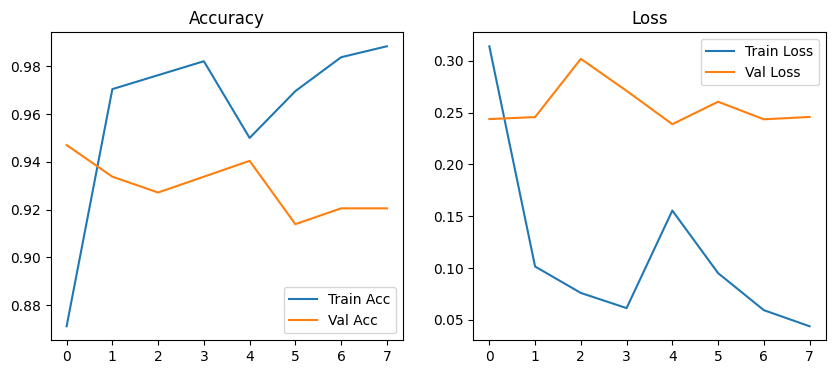

In [ ]:
# ===============================
# VẼ BIỂU ĐỒ HUẤN LUYỆN
# ===============================
def plot_history(history1, history2):
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.legend(); plt.title('Accuracy')

    plt.subplot(1,2,2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend(); plt.title('Loss')
    plt.show()

plot_history(history_head, history_fine)


Nhận xét:


*   Đồ thị Accuracy: có dấu hiệu học vẹt (overfitting) vì đường Train Acc tăng vọt lên gần 99%.Trong khi đó, đường Val Acc lại chững lại, thậm chí có xu hướng giảm nhẹ, chỉ dao động quanh mức 92-94%.
*   Đồ thị Loss :Đường Train Loss giảm mạnh xuống gần 0 (mô hình gần như thuộc lòng dữ liệu train).Nhưng đường Val Loss lại không giảm tương xứng, thậm chí có lúc còn tăng lên.


*   Ý nghĩa: Khoảng cách giữa đường train và val ngày càng lớn. Điều này có nghĩa là mô hình ResNet50 đang trở nên quá giỏi trong việc "nhớ" các bức ảnh huấn luyện, nhưng lại mất đi khả năng áp dụng kiến thức đó cho các bức ảnh mới. Nó đang học thuộc lòng thay vì học hiểu.










In [ ]:
# ===============================
#  ĐÁNH GIÁ MÔ HÌNH TRÊN TEST SET
# ===============================
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

pred_probs = model.predict(test_gen, steps=test_gen.samples)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Found 138 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


138/138 ━━━━━━━━━━━━━━━━━━━━ 28s 190ms/step
Classification Report:
              precision    recall  f1-score   support

     healthy       0.98      0.75      0.85        56
   unhealthy       0.85      0.99      0.92        82

    accuracy                           0.89       138
   macro avg       0.91      0.87      0.88       138
weighted avg       0.90      0.89      0.89       138

Confusion Matrix:
[[42 14]
 [ 1 81]]


In [ ]:
print("\n--- ĐÁNH GIÁ MÔ HÌNH TRÊN TẬP TEST ---")
# Recompile the model before evaluation and prediction
model.compile(
    optimizer=Adam(learning_rate=1e-5), # Use the same optimizer and learning rate as fine-tuning
    loss='categorical_crossentropy', # Use the same loss function
    metrics=['accuracy'] # Use the metrics you used for training
)

loss, accuracy = model.evaluate(test_gen, steps=test_gen.samples)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Y_pred = model.predict(test_gen, steps=test_gen.samples)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# Phân tích kết quả với các ngưỡng khác nhau
for threshold in [0.7, 0.8, 0.9]:
    print(f"\n--- KẾT QUẢ VỚI NGƯỠNG = {threshold} ---")
    # To show the effect of thresholding on the 'unhealthy' class (index 1), we can calculate
    # binary predictions based on the threshold for the 'unhealthy' probability.
    y_pred_thresholded = (Y_pred[:, 1] > threshold).astype(int)
    print(classification_report(y_true, y_pred_thresholded, target_names=class_names))


--- ĐÁNH GIÁ MÔ HÌNH TRÊN TẬP TEST ---
138/138 ━━━━━━━━━━━━━━━━━━━━ 30s 191ms/step - accuracy: 0.7833 - loss: 0.7088
Test Loss: 0.3295
Test Accuracy: 0.8913
138/138 ━━━━━━━━━━━━━━━━━━━━ 28s 189ms/step

--- KẾT QUẢ VỚI NGƯỠNG = 0.7 ---
              precision    recall  f1-score   support

     healthy       0.98      0.79      0.87        56
   unhealthy       0.87      0.99      0.93        82

    accuracy                           0.91       138
   macro avg       0.92      0.89      0.90       138
weighted avg       0.91      0.91      0.90       138


--- KẾT QUẢ VỚI NGƯỠNG = 0.8 ---
              precision    recall  f1-score   support

     healthy       0.92      0.80      0.86        56
   unhealthy       0.88      0.95      0.91        82

    accuracy                           0.89       138
   macro avg       0.90      0.88      0.88       138
weighted avg       0.89      0.89      0.89       138


--- KẾT QUẢ VỚI NGƯỠNG = 0.9 ---
              precision    recall  f1-scor


--- TẢI MÔ HÌNH TỪ: /content/best_resnet50_finetune.h5 ---


Tải mô hình thành công.

--- BẮT ĐẦU DỰ ĐOÁN TRÊN 5 ẢNH NGẪU NHIÊN ---

--- Đang dự đoán ảnh: h42_1.png ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Xác suất dự đoán (raw output): 0.6142
Ngưỡng quyết định được áp dụng: 0.5
==> KẾT QUẢ DỰ ĐOÁN: 'healthy' với độ tin cậy 38.58%


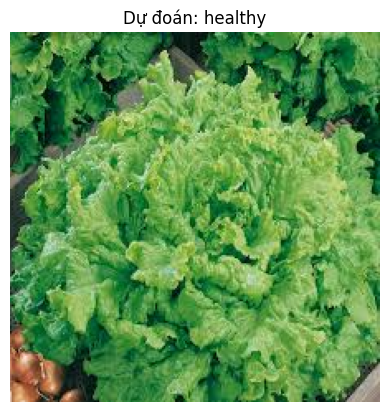


--- Đang dự đoán ảnh: h82_3.png ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Xác suất dự đoán (raw output): 0.6043
Ngưỡng quyết định được áp dụng: 0.5
==> KẾT QUẢ DỰ ĐOÁN: 'healthy' với độ tin cậy 39.57%


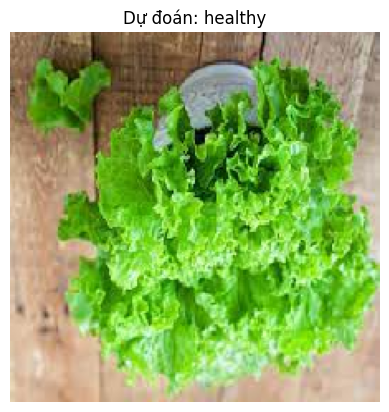


--- Đang dự đoán ảnh: augmented_29.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
Xác suất dự đoán (raw output): 0.6210
Ngưỡng quyết định được áp dụng: 0.5
==> KẾT QUẢ DỰ ĐOÁN: 'healthy' với độ tin cậy 37.90%


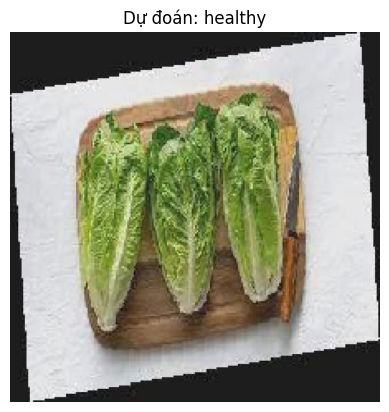


--- Đang dự đoán ảnh: augmented_49.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Xác suất dự đoán (raw output): 0.5274
Ngưỡng quyết định được áp dụng: 0.5
==> KẾT QUẢ DỰ ĐOÁN: 'healthy' với độ tin cậy 47.26%


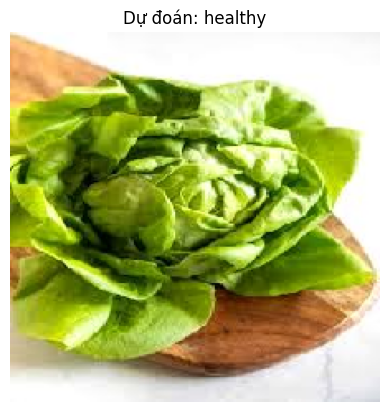


--- Đang dự đoán ảnh: augmented_44.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Xác suất dự đoán (raw output): 0.6481
Ngưỡng quyết định được áp dụng: 0.5
==> KẾT QUẢ DỰ ĐOÁN: 'healthy' với độ tin cậy 35.19%


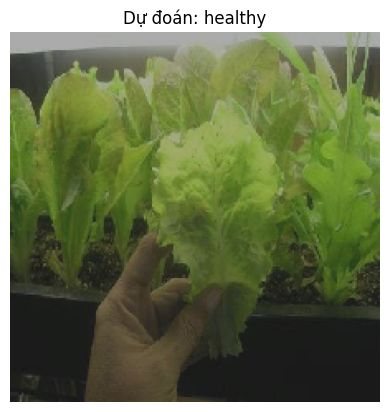

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.metrics import classification_report # Import classification_report

# Các tham số cần thiết (đảm bảo chúng khớp với lúc huấn luyện)
IMG_WIDTH, IMG_HEIGHT = 224, 224

def predict_single_image(loaded_model, img_path, class_indices, threshold=0.5):
    try:
        # Tải và tiền xử lý ảnh
        img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Dự đoán xác suất
        prediction_prob = loaded_model.predict(img_array)[0][0]

        # Áp dụng ngưỡng để đưa ra quyết định cuối cùng
        predicted_class_index = 1 if prediction_prob > threshold else 0

        # Lấy tên lớp từ index
        index_to_class = {v: k for k, v in class_indices.items()}
        predicted_class_name = index_to_class[predicted_class_index]

        # Tính toán độ tin cậy
        if predicted_class_name == 'unhealthy':
            confidence = prediction_prob
        else:
            confidence = 1 - prediction_prob

        print(f"Xác suất dự đoán (raw output): {prediction_prob:.4f}")
        print(f"Ngưỡng quyết định được áp dụng: {threshold}")
        print(f"==> KẾT QUẢ DỰ ĐOÁN: '{predicted_class_name}' với độ tin cậy {confidence:.2%}")

        # Hiển thị ảnh và kết quả
        plt.imshow(img)
        plt.title(f"Dự đoán: {predicted_class_name}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {img_path}: {e}")


def predict_random_images_from_folder(model_path, folder_path, class_indices, num_images=5, threshold=0.5):

    print(f"\n--- TẢI MÔ HÌNH TỪ: {model_path} ---")
    try:
        loaded_model = load_model(model_path)
        # Compile the loaded model
        loaded_model.compile(
            optimizer='adam', # Use the optimizer you used for training
            loss='categorical_crossentropy', # Use the loss you used for training
            metrics=['accuracy'] # Use the metrics you used for training
        )
        print("Tải mô hình thành công.")
    except Exception as e:
        print(f"Lỗi khi tải mô hình: {e}")
        return

    # Lấy danh sách tất cả các tệp ảnh trong thư mục
    try:
        all_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy thư mục tại '{folder_path}'")
        return

    if not all_images:
        print(f"Lỗi: Không tìm thấy tệp ảnh nào trong thư mục '{folder_path}'")
        return

    # Giới hạn số lượng ảnh nếu thư mục không có đủ
    if len(all_images) < num_images:
        print(f"Cảnh báo: Chỉ tìm thấy {len(all_images)} ảnh, sẽ dự đoán trên tất cả.")
        num_images = len(all_images)

    # Chọn ngẫu nhiên các ảnh từ danh sách
    random_images = random.sample(all_images, num_images)
    print(f"\n--- BẮT ĐẦU DỰ ĐOÁN TRÊN {num_images} ẢNH NGẪU NHIÊN ---")

    # Lặp qua các ảnh đã chọn và dự đoán
    for img_name in random_images:
        img_path = os.path.join(folder_path, img_name)
        print(f"\n--- Đang dự đoán ảnh: {img_name} ---")
        predict_single_image(loaded_model, img_path, class_indices, threshold)


# --- CÁCH SỬ DỤNG HÀM ---

# Đường dẫn tới mô hình tốt nhất bạn đã lưu
final_model_path = '/content/best_resnet50_finetune.h5'


# Ví dụ: kiểm tra trong thư mục con 'healthy' của tập test
image_folder_path = '/content/drive/MyDrive/Colab Notebooks/tap-trending/test/healthy'

# Lấy class_indices từ generator của bạn (bạn có thể chạy lại bước tạo generator để lấy biến này)
# Ví dụ: class_labels = train_generator.class_indices
class_labels = {'healthy': 1, 'unhealthy': 0} # Thay thế bằng giá trị thực tế nếu cần

if os.path.exists(final_model_path) and os.path.exists(image_folder_path):
    # Gọi hàm để kiểm tra 5 ảnh ngẫu nhiên từ thư mục đã chỉ định
    predict_random_images_from_folder(final_model_path, image_folder_path, class_labels, num_images=5, threshold=0.5)
else:
    print("Lỗi: Không tìm thấy tệp mô hình hoặc thư mục ảnh. Vui lòng kiểm tra lại đường dẫn.")

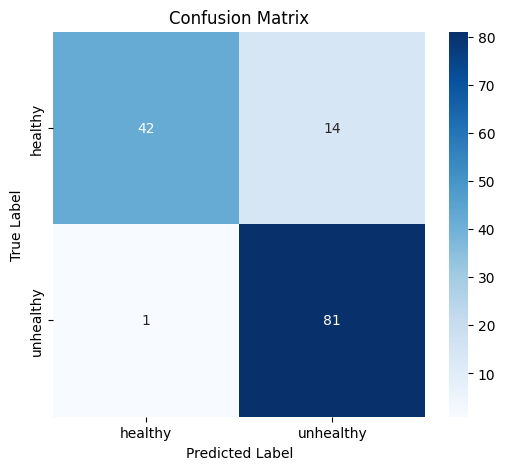

In [ ]:
import seaborn as sns

# ===============================
# TRỰC QUAN HÓA MA TRẬN NHẦM LẪN
# ===============================

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_true, y_pred, labels=np.arange(len(class_labels))),
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Ngưỡng tối ưu theo ROC: 0.958


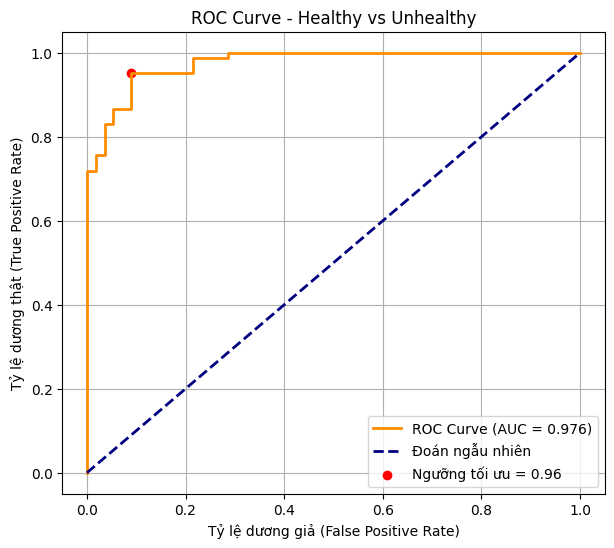


--- 🔍 ĐÁNH GIÁ THEO NGƯỠNG TỐI ƯU ---
              precision    recall  f1-score   support

     healthy       0.93      0.91      0.92        56
   unhealthy       0.94      0.95      0.95        82

    accuracy                           0.93       138
   macro avg       0.93      0.93      0.93       138
weighted avg       0.93      0.93      0.93       138


Confusion Matrix:
[[51  5]
 [ 4 78]]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

# ============================
# 🔹 Tính ROC Curve và AUC
# ============================
fpr, tpr, thresholds = roc_curve(y_true, Y_pred[:, 1])  # cột 1 là class "unhealthy"
roc_auc = auc(fpr, tpr)

# ============================
# 🔹 Tìm ngưỡng tối ưu (maximize tpr - fpr)
# ============================
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Ngưỡng tối ưu theo ROC: {optimal_threshold:.3f}")

# ============================
# 🔹 Vẽ biểu đồ ROC
# ============================
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Đoán ngẫu nhiên')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Ngưỡng tối ưu = {optimal_threshold:.2f}')
plt.xlabel('Tỷ lệ dương giả (False Positive Rate)')
plt.ylabel('Tỷ lệ dương thật (True Positive Rate)')
plt.title('ROC Curve - Healthy vs Unhealthy')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ============================
# 🔹 Đánh giá lại theo ngưỡng tối ưu
# ============================
y_pred_optimal = (Y_pred[:, 1] >= optimal_threshold).astype(int)

print("\n--- 🔍 ĐÁNH GIÁ THEO NGƯỠNG TỐI ƯU ---")
print(classification_report(y_true, y_pred_optimal, target_names=['healthy', 'unhealthy']))

cm = confusion_matrix(y_true, y_pred_optimal)
print("\nConfusion Matrix:")
print(cm)

# Xây dựng mô hình MobileNetV2

##Chuẩn bị dữ liệu và tăng cường cho tập train

In [ ]:

#Import các thư viện cần thiết
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

# Kiểm tra phiên bản TensorFlow
print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.19.0


In [ ]:
#Chuẩn bị dữ liệu và các tham số huấn luyện
train_dir = "/content/drive/MyDrive/Colab Notebooks/tap-trending/train"
val_dir = "/content/drive/MyDrive/Colab Notebooks/tap-trending/valid"

# Tham số huấn luyện
IMG_SIZE = 224  # Kích thước ảnh đầu vào cho MobileNetV2
BATCH_SIZE = 16  # Batch size nhỏ phù hợp với CPU
EPOCHS = 30
LEARNING_RATE = 0.0001

# Kiểm tra số lượng classes
classes = os.listdir(train_dir)
NUM_CLASSES = len(classes)
print(f"Số lượng classes: {NUM_CLASSES}")
print(f"Danh sách classes: {classes}")


Số lượng classes: 2
Danh sách classes: ['unhealthy', 'healthy']


In [ ]:
# Data Augmentation cho tập train để tăng tính đa dạng
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Chuẩn hóa pixel về [0,1]
    rotation_range=20,           # Xoay ngẫu nhiên ±20 độ
    width_shift_range=0.2,       # Dịch ngang 20%
    height_shift_range=0.2,      # Dịch dọc 20%
    shear_range=0.2,             # Biến dạng nghiêng
    zoom_range=0.2,              # Zoom in/out 20%
    horizontal_flip=True,        # Lật ngang ngẫu nhiên
    fill_mode='nearest'          # Điền pixel bị thiếu
)

# Chỉ rescale cho tập validation (không augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load dữ liệu từ thư mục
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',    # Multi-class classification
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False                # Không shuffle để đánh giá đúng
)

# Lưu mapping classes
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
print(f"\nClass mapping: {class_indices}")


Found 2399 images belonging to 2 classes.
Found 151 images belonging to 2 classes.

Class mapping: {'healthy': 0, 'unhealthy': 1}


In [ ]:
# Load MobileNetV2 pretrained trên ImageNet (không bao gồm top layer)
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,           # Bỏ fully connected layers
    weights='imagenet'           # Sử dụng pretrained weights
)

# Đóng băng các layer của base model (sẽ mở sau)
base_model.trainable = False

# Define NUM_CLASSES here (Moved outside Sequential)
NUM_CLASSES = 2 # Assuming 2 classes based on previous cells


# Xây dựng mô hình hoàn chỉnh
model = keras.Sequential([
    base_model,

    # Global Average Pooling để giảm số tham số
    layers.GlobalAveragePooling2D(),

    # Batch Normalization để ổn định quá trình training
    layers.BatchNormalization(),

    # Dropout để tránh overfitting
    layers.Dropout(0.3),

    # Dense layer với regularization
    layers.Dense(256, activation='relu',
                 kernel_regularizer=keras.regularizers.l2(0.001)),

    layers.BatchNormalization(),
    layers.Dropout(0.4),

    # Output layer
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# In tóm tắt mô hình
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,592,578 (9.89 MB)

 Trainable params: 331,522 (1.26 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

In [ ]:
# Compile mô hình
# Define LEARNING_RATE here
LEARNING_RATE = 0.0001 # Assuming this is the intended value from previous cells

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

# Callbacks để tối ưu quá trình training
callbacks = [
    # Early Stopping: dừng khi val_loss không giảm sau 5 epochs
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    # ReduceLROnPlateau: giảm learning rate khi val_loss không cải thiện
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    # ModelCheckpoint: lưu model tốt nhất
    keras.callbacks.ModelCheckpoint(
        '/content/best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks đã được thiết lập!")

Callbacks đã được thiết lập!


## Training phase 1

In [ ]:
print("=" * 60)
print("PHASE 1: Training top layers (base model frozen)")
print("=" * 60)

# Training phase 1
history_phase1 = model.fit(
    train_generator,
    epochs=10,  # Train 10 epochs đầu
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)


PHASE 1: Training top layers (base model frozen)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6753 - loss: 1.2188 - precision_1: 0.6753 - recall_1: 0.6753
Epoch 1: val_accuracy improved from -inf to 0.84768, saving model to /content/best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 1221s 8s/step - accuracy: 0.6758 - loss: 1.2174 - precision_1: 0.6758 - recall_1: 0.6758 - val_accuracy: 0.8477 - val_loss: 0.7582 - val_precision_1: 0.8477 - val_recall_1: 0.8477 - learning_rate: 1.0000e-04
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8724 - loss: 0.7444 - precision_1: 0.8724 - recall_1: 0.8724
Epoch 2: val_accuracy did not improve from 0.84768
150/150 ━━━━━━━━━━━━━━━━━━━━ 67s 441ms/step - accuracy: 0.8724 - loss: 0.7444 - precision_1: 0.8724 - recall_1: 0.8724 - val_accuracy: 0.8411 - val_loss: 0.7085 - val_precision_1: 0.8411 - val_recall_1: 0.8411 - learning_rate: 1.0000e-04
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.8829 - loss: 0.7002 - precision_1: 0.8829 - recall_1: 0.8829
Epoch 3: val_accuracy improved from 0.84768 to 0.86093, saving model to /content/best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 438ms/step - accuracy: 0.8830 - loss: 0.7002 - precision_1: 0.8830 - recall_1: 0.8830 - val_accuracy: 0.8609 - val_loss: 0.6929 - val_precision_1: 0.8609 - val_recall_1: 0.8609 - learning_rate: 1.0000e-04
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9050 - loss: 0.6595 - precision_1: 0.9050 - recall_1: 0.9050
Epoch 4: val_accuracy improved from 0.86093 to 0.86755, saving model to /content/best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 78s 418ms/step - accuracy: 0.9051 - loss: 0.6594 - precision_1: 0.9051 - recall_1: 0.9051 - val_accuracy: 0.8675 - val_loss: 0.6885 - val_precision_1: 0.8675 - val_recall_1: 0.8675 - learning_rate: 1.0000e-04
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.9190 - loss: 0.6063 - precision_1: 0.9190 - recall_1: 0.9190
Epoch 5: val_accuracy improved from 0.86755 to 0.90066, saving model to /content/best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 64s 427ms/step - accuracy: 0.9189 - loss: 0.6065 - precision_1: 0.9189 - recall_1: 0.9189 - val_accuracy: 0.9007 - val_loss: 0.6841 - val_precision_1: 0.9007 - val_recall_1: 0.9007 - learning_rate: 1.0000e-04
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9276 - loss: 0.5969 - precision_1: 0.9276 - recall_1: 0.9276
Epoch 6: val_accuracy did not improve from 0.90066
150/150 ━━━━━━━━━━━━━━━━━━━━ 63s 422ms/step - accuracy: 0.9275 - loss: 0.5970 - precision_1: 0.9275 - recall_1: 0.9275 - val_accuracy: 0.8874 - val_loss: 0.6882 - val_precision_1: 0.8874 - val_recall_1: 0.8874 - learning_rate: 1.0000e-04
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9279 - loss: 0.5778 - precision_1: 0.9279 - recall_1: 0.9279
Epoch 7: val_accuracy improved from 0.90066 to 0.90728, saving model to /content/best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 63s 423ms/step - accuracy: 0.9279 - loss: 0.5778 - precision_1: 0.9279 - recall_1: 0.9279 - val_accuracy: 0.9073 - val_loss: 0.6642 - val_precision_1: 0.9073 - val_recall_1: 0.9073 - learning_rate: 1.0000e-04
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.9312 - loss: 0.5671 - precision_1: 0.9312 - recall_1: 0.9312
Epoch 8: val_accuracy did not improve from 0.90728
150/150 ━━━━━━━━━━━━━━━━━━━━ 63s 417ms/step - accuracy: 0.9312 - loss: 0.5670 - precision_1: 0.9312 - recall_1: 0.9312 - val_accuracy: 0.8874 - val_loss: 0.6388 - val_precision_1: 0.8874 - val_recall_1: 0.8874 - learning_rate: 1.0000e-04
Epoch 9/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9260 - loss: 0.5754 - precision_1: 0.9260 - recall_1: 0.9260
Epoch 9: val_accuracy did not improve from 0.90728
150/150 ━━━━━━━━━━━━━━━━━━━━ 63s 418ms/step - accuracy: 0.9260 - loss: 0.5753 - precision_1: 0.9260 - recall_1: 0.9260 - val_accuracy: 0.8874 - val_loss: 0.6559 - v

150/150 ━━━━━━━━━━━━━━━━━━━━ 64s 427ms/step - accuracy: 0.9266 - loss: 0.5545 - precision_1: 0.9266 - recall_1: 0.9266 - val_accuracy: 0.9205 - val_loss: 0.6563 - val_precision_1: 0.9205 - val_recall_1: 0.9205 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 8.


##Training phase 2

In [ ]:
print("\n" + "=" * 60)
print("PHASE 2: Fine-tuning (unfreeze last layers)")
print("=" * 60)

# Mở khóa các layer cuối của base model để fine-tune
base_model.trainable = True

# Đóng băng các layer đầu, chỉ train từ layer 100 trở đi
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile với learning rate thấp hơn cho fine-tuning
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE / 10),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

# Define EPOCHS here
EPOCHS = 30 # Assuming 30 epochs for the fine-tuning phase

# Tiếp tục training
history_phase2 = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)


PHASE 2: Fine-tuning (unfreeze last layers)
Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.8673 - loss: 0.7394 - precision_2: 0.8673 - recall_2: 0.8673
Epoch 1: val_accuracy did not improve from 0.92053
150/150 ━━━━━━━━━━━━━━━━━━━━ 109s 561ms/step - accuracy: 0.8673 - loss: 0.7392 - precision_2: 0.8673 - recall_2: 0.8673 - val_accuracy: 0.9139 - val_loss: 0.7799 - val_precision_2: 0.9139 - val_recall_2: 0.9139 - learning_rate: 1.0000e-05
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9051 - loss: 0.6588 - precision_2: 0.9051 - recall_2: 0.9051
Epoch 2: val_accuracy did not improve from 0.92053
150/150 ━━━━━━━━━━━━━━━━━━━━ 64s 427ms/step - accuracy: 0.9051 - loss: 0.6588 - precision_2: 0.9051 - recall_2: 0.9051 - val_accuracy: 0.8742 - val_loss: 0.8803 - val_precision_2: 0.8742 - val_recall_2: 0.8742 - learning_rate: 1.0000e-05
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9175 - loss: 0.6191 - precision_2: 0.9175 - recall

150/150 ━━━━━━━━━━━━━━━━━━━━ 64s 429ms/step - accuracy: 0.9237 - loss: 0.5890 - precision_2: 0.9237 - recall_2: 0.9237 - val_accuracy: 0.9272 - val_loss: 0.7301 - val_precision_2: 0.9272 - val_recall_2: 0.9272 - learning_rate: 1.0000e-05
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9376 - loss: 0.5686 - precision_2: 0.9376 - recall_2: 0.9376
Epoch 5: val_accuracy did not improve from 0.92715
150/150 ━━━━━━━━━━━━━━━━━━━━ 63s 421ms/step - accuracy: 0.9376 - loss: 0.5685 - precision_2: 0.9376 - recall_2: 0.9376 - val_accuracy: 0.9272 - val_loss: 0.6632 - val_precision_2: 0.9272 - val_recall_2: 0.9272 - learning_rate: 1.0000e-05
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9558 - loss: 0.5199 - precision_2: 0.9558 - recall_2: 0.9558
Epoch 6: val_accuracy improved from 0.92715 to 0.93377, saving model to /content/best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 64s 425ms/step - accuracy: 0.9557 - loss: 0.5200 - precision_2: 0.9557 - recall_2: 0.9557 - val_accuracy: 0.9338 - val_loss: 0.5997 - val_precision_2: 0.9338 - val_recall_2: 0.9338 - learning_rate: 1.0000e-05
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9495 - loss: 0.5341 - precision_2: 0.9495 - recall_2: 0.9495
Epoch 7: val_accuracy improved from 0.93377 to 0.96026, saving model to /content/best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 64s 429ms/step - accuracy: 0.9495 - loss: 0.5341 - precision_2: 0.9495 - recall_2: 0.9495 - val_accuracy: 0.9603 - val_loss: 0.5649 - val_precision_2: 0.9603 - val_recall_2: 0.9603 - learning_rate: 1.0000e-05
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.9544 - loss: 0.5075 - precision_2: 0.9544 - recall_2: 0.9544
Epoch 8: val_accuracy improved from 0.96026 to 0.96689, saving model to /content/best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 66s 437ms/step - accuracy: 0.9544 - loss: 0.5076 - precision_2: 0.9544 - recall_2: 0.9544 - val_accuracy: 0.9669 - val_loss: 0.5438 - val_precision_2: 0.9669 - val_recall_2: 0.9669 - learning_rate: 1.0000e-05
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9450 - loss: 0.5291 - precision_2: 0.9450 - recall_2: 0.9450
Epoch 9: val_accuracy improved from 0.96689 to 0.97351, saving model to /content/best_model.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 65s 432ms/step - accuracy: 0.9450 - loss: 0.5291 - precision_2: 0.9450 - recall_2: 0.9450 - val_accuracy: 0.9735 - val_loss: 0.5378 - val_precision_2: 0.9735 - val_recall_2: 0.9735 - learning_rate: 1.0000e-05
Epoch 10/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9507 - loss: 0.5102 - precision_2: 0.9507 - recall_2: 0.9507
Epoch 10: val_accuracy did not improve from 0.97351
150/150 ━━━━━━━━━━━━━━━━━━━━ 65s 431ms/step - accuracy: 0.9506 - loss: 0.5103 - precision_2: 0.9506 - recall_2: 0.9506 - val_accuracy: 0.9536 - val_loss: 0.5485 - val_precision_2: 0.9536 - val_recall_2: 0.9536 - learning_rate: 1.0000e-05
Epoch 11/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.9567 - loss: 0.4970 - precision_2: 0.9567 - recall_2: 0.9567
Epoch 11: val_accuracy did not improve from 0.97351
150/150 ━━━━━━━━━━━━━━━━━━━━ 64s 426ms/step - accuracy: 0.9567 - loss: 0.4970 - precision_2: 0.9567 - recall_2: 0.9567 - val_accuracy: 0.9603 - val_loss: 0.5399

##Kết quả huấn luyện và đánh giá MobileNetV2

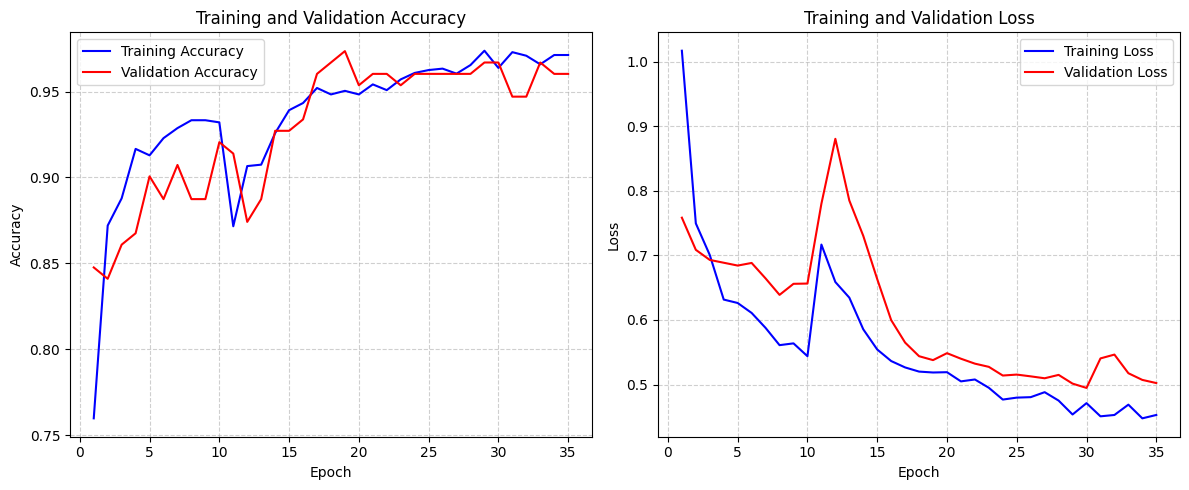

In [ ]:
import matplotlib.pyplot as plt

def plot_acc_loss(history1, history2=None):
    # Kết hợp 2 phase
    if history2:
        acc = history1.history['accuracy'] + history2.history['accuracy']
        val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
        loss = history1.history['loss'] + history2.history['loss']
        val_loss = history1.history['val_loss'] + history2.history['val_loss']
    else:
        acc = history1.history['accuracy']
        val_acc = history1.history['val_accuracy']
        loss = history1.history['loss']
        val_loss = history1.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Vẽ đồ thị Accuracy và Loss
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Gọi hàm
plot_acc_loss(history_phase1, history_phase2)


Nhận xét:


*   Đồ thị Accuracy: Đây là một biểu đồ huấn luyện lý tưởng. Đường Training Accuracy  và đường Validation Accuracy bám sát .Cả hai cùng tăng đều và kết thúc ở mức rất cao (trên 95%).
*   Đồ thị Loss : đường Training Loss và Validation Loss cùng nhau giảm dần. Mặc dù Validation Loss có một vài gai nhọn (điều này là bình thường, cho thấy mô hình đang "vật lộn" để học), xu hướng chung là giảm.

*   Ý nghĩa: Điều này cho thấy mô hình MobileNetV2 học một cách tổng quát. Những gì nó học được từ dữ liệu huấn luyện (train) đều có thể áp dụng rất tốt cho dữ liệu mới mà nó chưa từng thấy (validation). Không có dấu hiệu của việc học vẹt.





In [ ]:
print("=" * 60)
print("ĐÁNH GIÁ MÔ HÌNH TRÊN TẬP VALIDATION")
print("=" * 60)

# Đánh giá mô hình
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_generator, verbose=1)

# Tính F1-Score
val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall + 1e-7)

print(f"\n{'Metric':<20} {'Value':>10}")
print("-" * 35)
print(f"{'Validation Loss':<20} {val_loss:>10.4f}")
print(f"{'Validation Accuracy':<20} {val_accuracy:>10.4f}")
print(f"{'Validation Precision':<20} {val_precision:>10.4f}")
print(f"{'Validation Recall':<20} {val_recall:>10.4f}")
print(f"{'Validation F1-Score':<20} {val_f1:>10.4f}")
print("-" * 35)


ĐÁNH GIÁ MÔ HÌNH TRÊN TẬP VALIDATION
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - accuracy: 0.9605 - loss: 0.5140 - precision_2: 0.9605 - recall_2: 0.9605

Metric                    Value
-----------------------------------
Validation Loss          0.4947
Validation Accuracy      0.9669
Validation Precision     0.9669
Validation Recall        0.9669
Validation F1-Score      0.9669
-----------------------------------


Đang dự đoán trên tập validation...
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 620ms/step


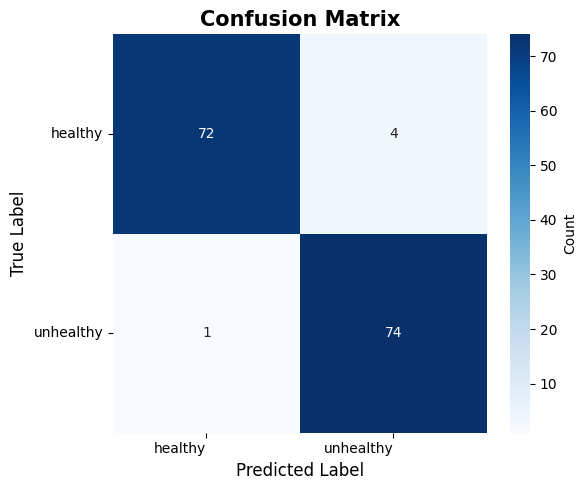

In [ ]:
# Reset generator để dự đoán từ đầu
val_generator.reset()

# Dự đoán trên tập validation
print("Đang dự đoán trên tập validation...")
predictions = model.predict(val_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Lấy true labels
true_classes = val_generator.classes

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(true_classes, predicted_classes)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=15, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=0, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [ ]:
print("\n" + "=" * 70)
print("BÁO CÁO PHÂN LOẠI CHI TIẾT")
print("=" * 70)

# Classification report
report = classification_report(
    true_classes,
    predicted_classes,
    target_names=class_names,
    digits=4
)
print(report)



BÁO CÁO PHÂN LOẠI CHI TIẾT
              precision    recall  f1-score   support

     healthy     0.9863    0.9474    0.9664        76
   unhealthy     0.9487    0.9867    0.9673        75

    accuracy                         0.9669       151
   macro avg     0.9675    0.9670    0.9669       151
weighted avg     0.9676    0.9669    0.9669       151



SO SÁNH HIỆU SUẤT GIỮA TRAINING VÀ VALIDATION
Độ chính xác trung bình (Training): 0.9359
Độ chính xác trung bình (Validation): 0.9290
Chênh lệch Accuracy trung bình: 0.0069
------------------------------------------------------------
Loss trung bình (Training): 0.5562
Loss trung bình (Validation): 0.6070
Chênh lệch Loss trung bình: 0.0508
✅ MÔ HÌNH ỔN: Không có dấu hiệu overfitting rõ ràng.


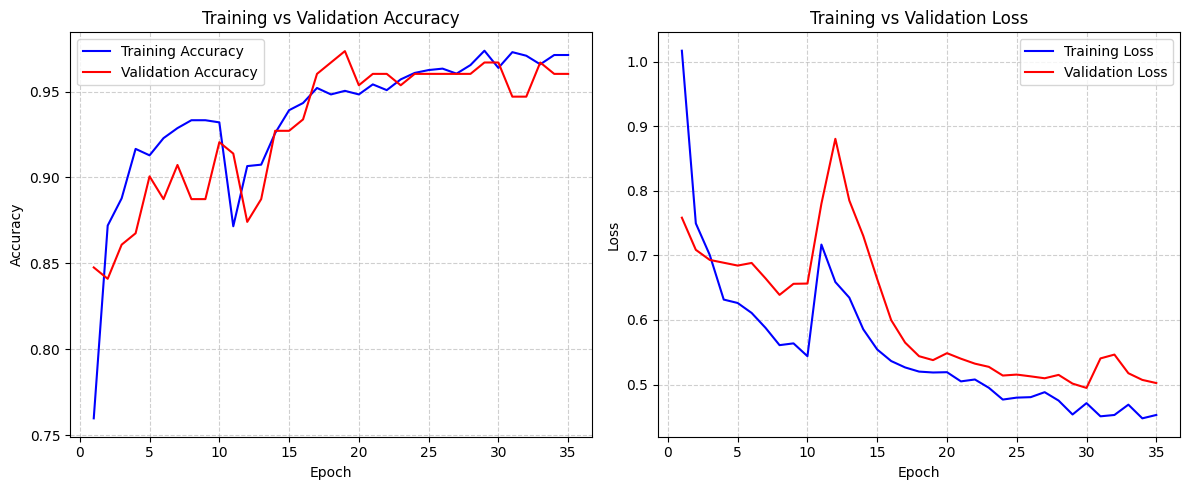

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def compare_train_val_performance(history1, history2=None):
    # Gộp history của 2 phase (nếu có)
    if history2:
        acc = history1.history['accuracy'] + history2.history['accuracy']
        val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
        loss = history1.history['loss'] + history2.history['loss']
        val_loss = history1.history['val_loss'] + history2.history['val_loss']
    else:
        acc = history1.history['accuracy']
        val_acc = history1.history['val_accuracy']
        loss = history1.history['loss']
        val_loss = history1.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Tạo DataFrame tổng hợp
    df_metrics = pd.DataFrame({
        'Epoch': epochs,
        'Train_Accuracy': acc,
        'Val_Accuracy': val_acc,
        'Train_Loss': loss,
        'Val_Loss': val_loss
    })

    # In các giá trị trung bình và chênh lệch
    print("=" * 60)
    print("SO SÁNH HIỆU SUẤT GIỮA TRAINING VÀ VALIDATION")
    print("=" * 60)
    print(f"Độ chính xác trung bình (Training): {df_metrics['Train_Accuracy'].mean():.4f}")
    print(f"Độ chính xác trung bình (Validation): {df_metrics['Val_Accuracy'].mean():.4f}")
    print(f"Chênh lệch Accuracy trung bình: {(df_metrics['Train_Accuracy'].mean() - df_metrics['Val_Accuracy'].mean()):.4f}")
    print("-" * 60)
    print(f"Loss trung bình (Training): {df_metrics['Train_Loss'].mean():.4f}")
    print(f"Loss trung bình (Validation): {df_metrics['Val_Loss'].mean():.4f}")
    print(f"Chênh lệch Loss trung bình: {(df_metrics['Val_Loss'].mean() - df_metrics['Train_Loss'].mean()):.4f}")
    print("=" * 60)

    # Đánh giá tình trạng overfitting
    acc_gap = df_metrics['Train_Accuracy'].iloc[-1] - df_metrics['Val_Accuracy'].iloc[-1]
    if acc_gap > 0.1 and df_metrics['Val_Loss'].iloc[-1] > df_metrics['Train_Loss'].iloc[-1]:
        print("⚠️ DẤU HIỆU OVERFITTING: Accuracy train cao hơn nhiều so với validation, val_loss tăng cao.")
    else:
        print("✅ MÔ HÌNH ỔN: Không có dấu hiệu overfitting rõ ràng.")

    # Vẽ biểu đồ Accuracy & Loss
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    return df_metrics

# Gọi hàm so sánh (sau khi bạn có history_phase1 và history_phase2)
metrics_df = compare_train_val_performance(history_phase1, history_phase2)



--- TẢI MÔ HÌNH TỪ: /content/best_model.h5 ---


Tải mô hình thành công.

--- BẮT ĐẦU DỰ ĐOÁN TRÊN 5 ẢNH NGẪU NHIÊN ---

--- Đang dự đoán ảnh: augmented_46.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Xác suất dự đoán (raw output): 0.4227
Ngưỡng quyết định được áp dụng: 0.5
==> KẾT QUẢ DỰ ĐOÁN: 'unhealthy' với độ tin cậy 42.27%


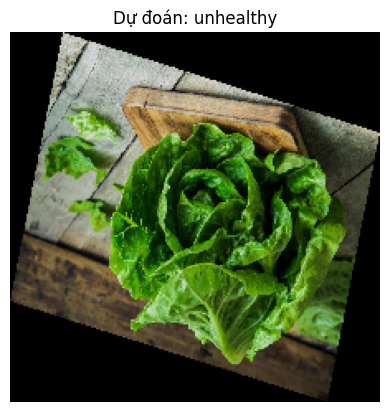


--- Đang dự đoán ảnh: augmented_0.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Xác suất dự đoán (raw output): 0.9948
Ngưỡng quyết định được áp dụng: 0.5
==> KẾT QUẢ DỰ ĐOÁN: 'healthy' với độ tin cậy 0.52%


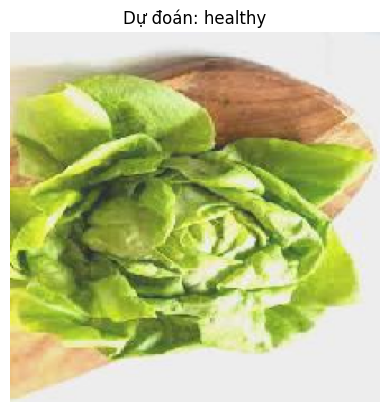


--- Đang dự đoán ảnh: augmented_41.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Xác suất dự đoán (raw output): 0.4273
Ngưỡng quyết định được áp dụng: 0.5
==> KẾT QUẢ DỰ ĐOÁN: 'unhealthy' với độ tin cậy 42.73%


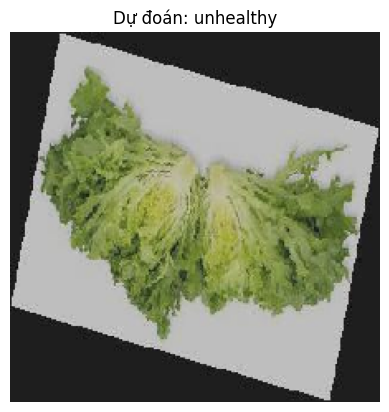


--- Đang dự đoán ảnh: h15_2.png ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Xác suất dự đoán (raw output): 0.9999
Ngưỡng quyết định được áp dụng: 0.5
==> KẾT QUẢ DỰ ĐOÁN: 'healthy' với độ tin cậy 0.01%


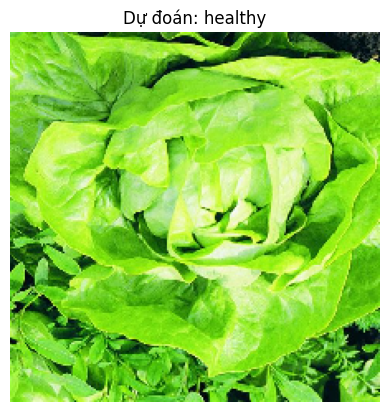


--- Đang dự đoán ảnh: augmented_16.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Xác suất dự đoán (raw output): 1.0000
Ngưỡng quyết định được áp dụng: 0.5
==> KẾT QUẢ DỰ ĐOÁN: 'healthy' với độ tin cậy 0.00%


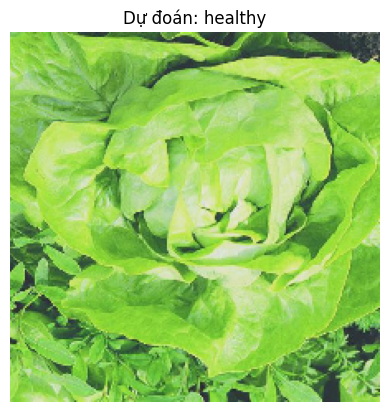

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.metrics import classification_report # Import classification_report

# Các tham số cần thiết (đảm bảo chúng khớp với lúc huấn luyện)
IMG_WIDTH, IMG_HEIGHT = 224, 224

def predict_single_image(loaded_model, img_path, class_indices, threshold=0.5):
    try:
        # Tải và tiền xử lý ảnh
        img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        # Dự đoán xác suất
        prediction_prob = loaded_model.predict(img_array)[0][0]

        # Áp dụng ngưỡng để đưa ra quyết định cuối cùng
        predicted_class_index = 1 if prediction_prob > threshold else 0

        # Lấy tên lớp từ index
        index_to_class = {v: k for k, v in class_indices.items()}
        predicted_class_name = index_to_class[predicted_class_index]

        # Tính toán độ tin cậy
        if predicted_class_name == 'unhealthy':
            confidence = prediction_prob
        else:
            confidence = 1 - prediction_prob

        print(f"Xác suất dự đoán (raw output): {prediction_prob:.4f}")
        print(f"Ngưỡng quyết định được áp dụng: {threshold}")
        print(f"==> KẾT QUẢ DỰ ĐOÁN: '{predicted_class_name}' với độ tin cậy {confidence:.2%}")

        # Hiển thị ảnh và kết quả
        plt.imshow(img)
        plt.title(f"Dự đoán: {predicted_class_name}")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {img_path}: {e}")


def predict_random_images_from_folder(model_path, folder_path, class_indices, num_images=5, threshold=0.5):

    print(f"\n--- TẢI MÔ HÌNH TỪ: {model_path} ---")
    try:
        loaded_model = load_model(model_path)
        # Compile the loaded model
        loaded_model.compile(
            optimizer='adam', # Use the optimizer you used for training
            loss='categorical_crossentropy', # Use the loss you used for training
            metrics=['accuracy'] # Use the metrics you used for training
        )
        print("Tải mô hình thành công.")
    except Exception as e:
        print(f"Lỗi khi tải mô hình: {e}")
        return

    # Lấy danh sách tất cả các tệp ảnh trong thư mục
    try:
        all_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy thư mục tại '{folder_path}'")
        return

    if not all_images:
        print(f"Lỗi: Không tìm thấy tệp ảnh nào trong thư mục '{folder_path}'")
        return

    # Giới hạn số lượng ảnh nếu thư mục không có đủ
    if len(all_images) < num_images:
        print(f"Cảnh báo: Chỉ tìm thấy {len(all_images)} ảnh, sẽ dự đoán trên tất cả.")
        num_images = len(all_images)

    # Chọn ngẫu nhiên các ảnh từ danh sách
    random_images = random.sample(all_images, num_images)
    print(f"\n--- BẮT ĐẦU DỰ ĐOÁN TRÊN {num_images} ẢNH NGẪU NHIÊN ---")

    # Lặp qua các ảnh đã chọn và dự đoán
    for img_name in random_images:
        img_path = os.path.join(folder_path, img_name)
        print(f"\n--- Đang dự đoán ảnh: {img_name} ---")
        predict_single_image(loaded_model, img_path, class_indices, threshold)


# --- CÁCH SỬ DỤNG HÀM ---

# Đường dẫn tới mô hình tốt nhất bạn đã lưu
final_model_path = '/content/best_model.h5'


# Ví dụ: kiểm tra trong thư mục con 'healthy' của tập test
image_folder_path = '/content/drive/MyDrive/Colab Notebooks/tap-trending/test/healthy'

# Lấy class_indices từ generator của bạn (bạn có thể chạy lại bước tạo generator để lấy biến này)
# Ví dụ: class_labels = train_generator.class_indices
class_labels = {'healthy': 1, 'unhealthy': 0} # Thay thế bằng giá trị thực tế nếu cần

if os.path.exists(final_model_path) and os.path.exists(image_folder_path):
    # Gọi hàm để kiểm tra 5 ảnh ngẫu nhiên từ thư mục đã chỉ định
    predict_random_images_from_folder(final_model_path, image_folder_path, class_labels, num_images=5, threshold=0.5)
else:
    print("Lỗi: Không tìm thấy tệp mô hình hoặc thư mục ảnh. Vui lòng kiểm tra lại đường dẫn.")

# Đánh giá Resnet50 và MobileNetV2

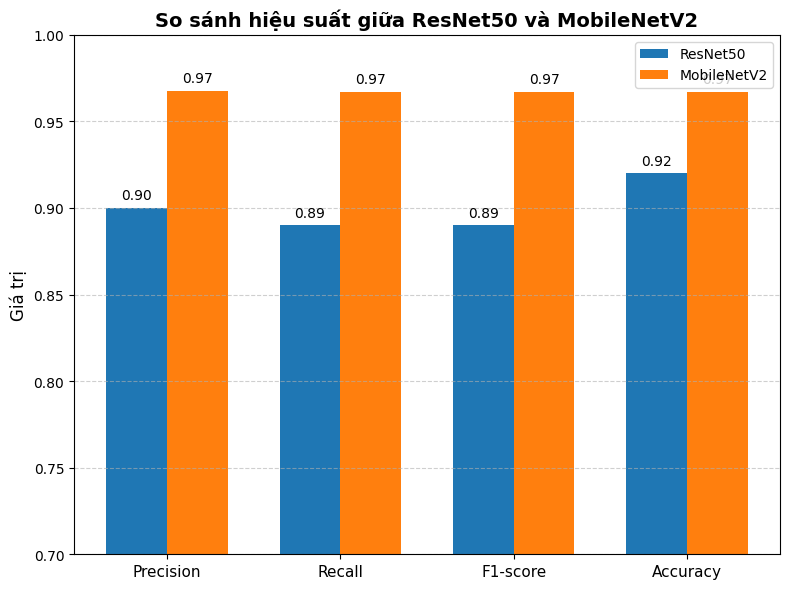

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# =============================
# DỮ LIỆU HIỆU SUẤT MÔ HÌNH
# =============================

metrics = ["Precision", "Recall", "F1-score", "Accuracy"]

# Giá trị trung bình (macro/weighted avg) từ bảng báo cáo
resnet50 = [0.90, 0.89, 0.89, 0.92]         # ResNet50
mobilenetv2 = [0.9676, 0.9670, 0.9669, 0.9669]  # MobileNetV2

# =============================
# VẼ BIỂU ĐỒ SO SÁNH
# =============================

x = np.arange(len(metrics))  # trục x
width = 0.35  # độ rộng của mỗi cột

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, resnet50, width, label="ResNet50", color="#1f77b4")
plt.bar(x + width/2, mobilenetv2, width, label="MobileNetV2", color="#ff7f0e")

plt.ylim(0.7, 1.0)
plt.ylabel("Giá trị", fontsize=12)
plt.title("So sánh hiệu suất giữa ResNet50 và MobileNetV2", fontsize=14, weight='bold')
plt.xticks(x, metrics, fontsize=11)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Hiển thị giá trị trên đầu cột
for i, v in enumerate(resnet50):
    plt.text(x[i] - width/2, v + 0.005, f"{v:.2f}", ha='center', fontsize=10)
for i, v in enumerate(mobilenetv2):
    plt.text(x[i] + width/2, v + 0.005, f"{v:.2f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()


Nhận xét 2 mô hình:

*   MobileNetV2 vượt trội hơn ResNet50 trên tất cả các chỉ số đánh giá.


*   Về Độ chính xác (Accuracy): MobileNetV2 đạt 97%,cao hơn đáng kể so với 90% của ResNet50.


*   Về các chỉ số chi tiết: Cả Precision, Recall, và F1-score của MobileNetV2 đều đạt mức 0.97 rất cao và cân bằng,trong khi ResNet50 chỉ đạt từ 0.89 đến 0.90.


*   Kết luận:Dựa trên biểu đồ so sánh này, MobileNetV2 là mô hình vượt trội hơn rõ rệt và cho kết quả tốt hơn hẳn.



